# Attempting to diagnose TCR

In [76]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 16, 9

In [77]:
from os.path import join, expanduser
from glob import glob

import numpy as np
import pymagicc
from pymagicc import rcp26, write_scen_file, _get_date_time_string
from pymagicc.input import MAGICCInput
from pymagicc.api import MAGICC6

In [78]:
MAGICC6_DIR = expanduser(join('~', 'Desktop', 'MAGICC6', ))
MAGICC6_RUN_DIR = join(MAGICC6_DIR, 'run', )

In [79]:
mi = MAGICCInput()
mi.read(filepath=MAGICC6_RUN_DIR, filename='HISTRCP_CO2_CONC.IN')

In [80]:
mi.metadata['header'] = '\n'.join([
    'TCR Diagnosis input file',
    'Written by: diagnose-tcr notebook in pymagicc package'
]) + '\n\n'
mi.df = mi.df.loc[mi.df.index.values[0][:-1] + (slice(1600, 2008),)]
mi.df.head()

VARIABLE  TODO  REGION  UNITS  YEAR
CO2_CONC  SET   GLOBAL  ppm    1600    276.333846
                               1601    276.200923
                               1602    276.070462
                               1603    275.949846
                               1604    275.846462
dtype: float64

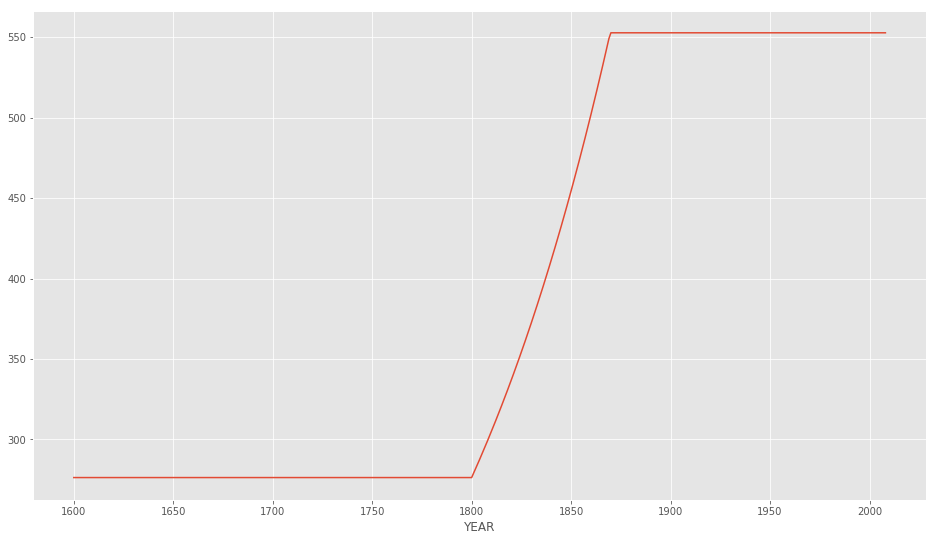

In [81]:
# working with this df is unreasonably difficult at the moment, something to fix...
PI_CO2 = mi.df.loc[mi.df.index.values[0]]
mi.df.loc[mi.df.index.values[0][:-1] + (slice(1010, 1800),)] = PI_CO2
mi.df.loc[mi.df.index.values[0][:-1] + (slice(1800, 1870),)] = PI_CO2 * 1.01**np.arange(0,71)
mi.df.loc[mi.df.index.values[0][:-1] + (slice(1870, 2008),)] = PI_CO2 * 2.
ax = mi.df.loc[mi.df.index.values[0][:-1]].plot()

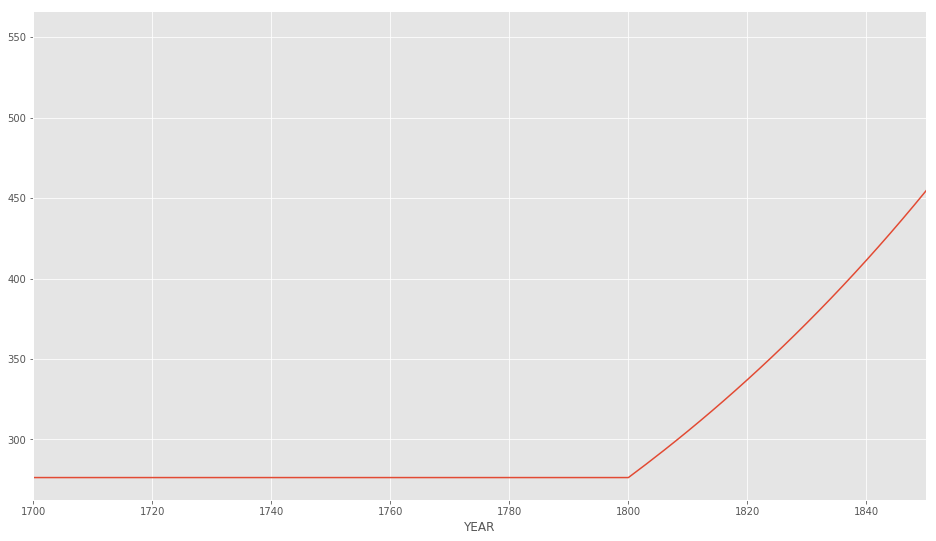

In [82]:
ax = mi.df.loc[mi.df.index.values[0][:-1]].plot()
ax.set_xlim([1700,1850]);

In [83]:
tcr_prefix = 'HISTTCR'
tcr_conf_config = {}
co2_conc_file = tcr_prefix + '_CO2_CONC.IN'
tcr_conf_config["FILE_CO2_CONC"] = co2_conc_file
mi.write(join(MAGICC6_RUN_DIR , tcr_conf_config["FILE_CO2_CONC"]))

In [84]:
# this needs to be fixed to use PI conc rather than 0
# mi.df.loc[mi.df.index.values[:]] = 0.
# for file in glob(join(MAGICC6_RUN_DIR, 'HISTRCP*CONC.IN')):
#     gas = file.split('_')[1]
#     if gas == 'CO2':
#         continue
#     conc_to_write = tcr_prefix + '_' + gas +'_CONC.IN'
#     tcr_conf_config["FILE_" + gas + "_CONC"] = conc_to_write
#     mi.write(join(MAGICC6_RUN_DIR , conc_to_write))

# ax = mi.df.loc[mi.df.index.values[0][:-1]].plot()

In [85]:
with MAGICC6(root_dir=MAGICC6_DIR) as magicc:
    # Write out the `Scenario` as a .SCEN-file.
    write_scen_file(rcp26,
                    join(magicc.run_dir, "SCENARIO.SCEN"))

    year_cfg = {}
    year_cfg['startyear'] = 1750
    year_cfg['endyear'] = 2008
    magicc.set_years(**year_cfg)
    
    print(tcr_conf_config)
    tcr_conf_config.setdefault("file_emissionscenario", "SCENARIO.SCEN")
    tcr_conf_config.setdefault("rundate", _get_date_time_string())
    tcr_conf_config["FILE_CO2_CONC"] = "HISTTCR_CO2_CONC.IN"

    magicc.set_config(**tcr_conf_config)

    results = magicc.run()
    
# results = pymagicc.run(
#     rcp26,
#     FILE_CO2_CONC=tcr_prefix + '_CO2_CONC.IN'
# )

{'FILE_CO2_CONC': 'HISTTCR_CO2_CONC.IN'}


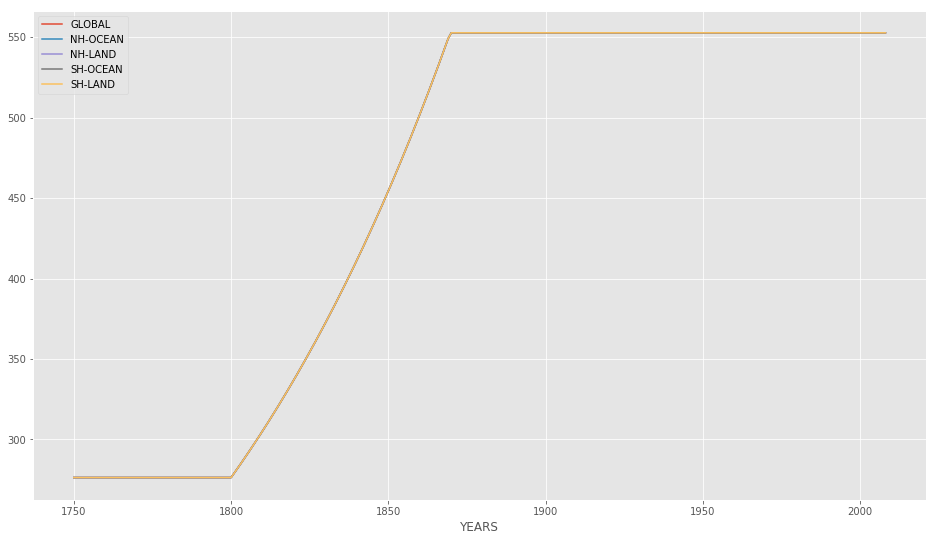

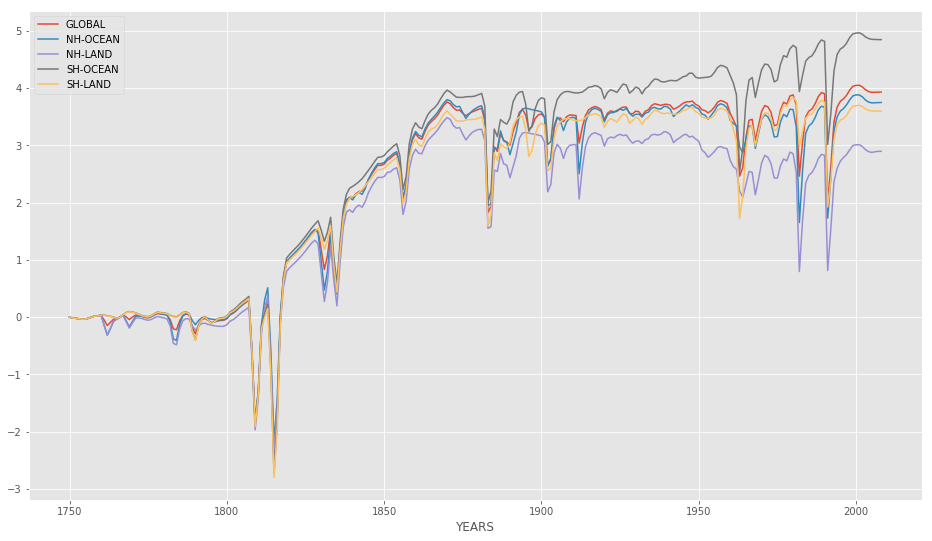

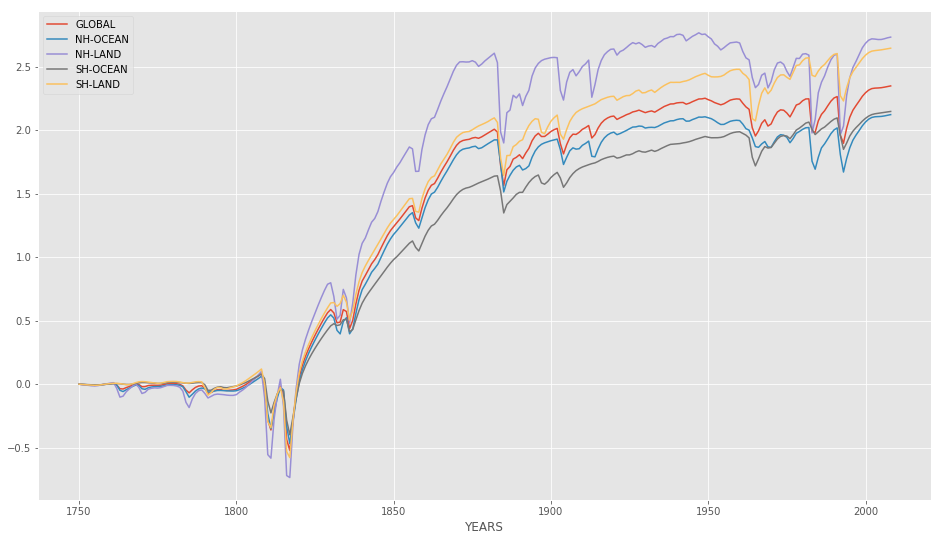

In [86]:
results['CO2_CONC'].plot()
results['TOTAL_INCLVOLCANIC_RF'].plot()
results['SURFACE_TEMP'].plot()